# Predicting burned calories using personal Apple Watch data


## Introduction

In this project I attempt to create a predictive model that can calculate burned calories based on heart rate, resting heart rate, cycled distance, steps and exercise minutes. I will be using Random Forest Regression algorithm and my personal data I collected with my Apple Watch.


In [1]:
import pandas as pd
import numpy as np
import math

import xmltodict #the library I will use to convert the data file to a dictionary
import calendar #the library I will use to turn numeric dates into names of months and weekdays

#libraries for data visualisation
import seaborn as sns
import matplotlib.pyplot as plt 

#libraries for building and evaluating my model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## 1. Importing and cleaning data

Importing the data file in xml format and turning it into a dictionary:

In [2]:
input_path = '/Users/dominykabortnikaite/Desktop/apple_health_export/export.xml'
with open(input_path, 'r') as xml_file:
    input_data = xmltodict.parse(xml_file.read())

We will only need the "HealthData" and "Record" keys from the dictionary.

In [3]:
records_list = input_data['HealthData']['Record']

In [4]:
df = pd.DataFrame(records_list) # creating a dataframe with the data I will use

In [5]:
df.head()

,@type,@sourceName,@sourceVersion,@unit,@creationDate,@startDate,@endDate,@value,@device,MetadataEntry,HeartRateVariabilityMetadataList
0,HKQuantityTypeIdentifierHeight,Dominyka’s iPhone,13.3.1,cm,2020-05-02 14:14:55 +0100,2020-05-02 14:14:55 +0100,2020-05-02 14:14:55 +0100,183,NaN,NaN,NaN
1,HKQuantityTypeIdentifierBodyMass,Dominyka’s iPhone,13.3.1,kg,2020-05-02 14:14:55 +0100,2020-05-02 14:14:55 +0100,2020-05-02 14:14:55 +0100,65,NaN,NaN,NaN
2,HKQuantityTypeIdentifierBodyMass,MyFitnessPal,29688,kg,2020-05-07 09:22:18 +0100,2020-05-02 09:22:00 +0100,2020-05-02 09:22:00 +0100,63,NaN,NaN,NaN
3,HKQuantityTypeIdentifierHeartRate,Dominyka’s Apple Watch,6.1.3,count/min,2020-05-02 14:30:38 +0100,2020-05-02 14:28:34 +0100,2020-05-02 14:28:34 +0100,66,"<<HKDevice: 0x280fb9f40>, name:Apple Watch, ma...",{'@key': 'HKMetadataKeyHeartRateMotionContext'...,NaN
4,HKQuantityTypeIdentifierHeartRate,Dominyka’s Apple Watch,6.1.3,count/min,2020-05-02 14:33:23 +0100,2020-05-02 14:33:23 +0100,2020-05-02 14:33:23 +0100,65,"<<HKDevice: 0x280fb9f40>, name:Apple Watch, ma...",{'@key': 'HKMetadataKeyHeartRateMotionContext'...,NaN


The file contains data from different sources. Let's see what the different sources are:

In [6]:
df['@sourceName'].unique()

array(['Dominyka’s iPhone', 'MyFitnessPal', 'Dominyka’s Apple\xa0Watch',
       'iPhone', 'Nike Training', 'Health', 'Clock', 'SleepWatch',
       'Headspace'], dtype=object)

Below I am extracting only the data that was collected with the Apple watch to avoid duplicates or overlapping data.

In [7]:
df = df[df['@sourceName'] == 'Dominyka’s Apple\xa0Watch']

Now I am going to see what are all the different measurements my Apple Watch has tracked:

In [8]:
df['@type'].unique()

array(['HKQuantityTypeIdentifierHeartRate',
       'HKQuantityTypeIdentifierStepCount',
       'HKQuantityTypeIdentifierDistanceWalkingRunning',
       'HKQuantityTypeIdentifierBasalEnergyBurned',
       'HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierFlightsClimbed',
       'HKQuantityTypeIdentifierAppleExerciseTime',
       'HKQuantityTypeIdentifierDistanceCycling',
       'HKQuantityTypeIdentifierRestingHeartRate',
       'HKQuantityTypeIdentifierVO2Max',
       'HKQuantityTypeIdentifierWalkingHeartRateAverage',
       'HKQuantityTypeIdentifierEnvironmentalAudioExposure',
       'HKQuantityTypeIdentifierAppleStandTime',
       'HKQuantityTypeIdentifierStairAscentSpeed',
       'HKQuantityTypeIdentifierStairDescentSpeed',
       'HKCategoryTypeIdentifierSleepAnalysis',
       'HKCategoryTypeIdentifierAppleStandHour',
       'HKCategoryTypeIdentifierMindfulSession',
       'HKCategoryTypeIdentifierHandwashingEvent',
       'HKQuantityTypeIdentifierHeartRa

For this project we will only need a few of those (steps, calories,cycling distance, exercise minutes, resting heart rate). Before we extract them, let's change the timestamps in the df to datetime objects:

In [9]:
format = '%Y-%m-%d %H:%M:%S %z'
df['@creationDate'] = pd.to_datetime(df['@creationDate'],
                                     format=format)
df['@startDate'] = pd.to_datetime(df['@startDate'],
                                  format=format)
df['@endDate'] = pd.to_datetime(df['@endDate'],
                                format=format)

Now I am going to select the measurements I need and create new dataframes for them.

In [10]:
step_counts = df[df['@type'] == 'HKQuantityTypeIdentifierStepCount']
energy_burned = df[df['@type'] == 'HKQuantityTypeIdentifierActiveEnergyBurned']
exercise_minutes = df[df['@type'] == 'HKQuantityTypeIdentifierAppleExerciseTime']
heart_rate = df[df['@type'] == 'HKQuantityTypeIdentifierHeartRate']
cycling = df[df['@type'] == 'HKQuantityTypeIdentifierDistanceCycling']
rhr = df[df['@type'] == 'HKQuantityTypeIdentifierRestingHeartRate']

Now I am going to see what data types are in these dataframes:

In [11]:
heart_rate.dtypes
#cycling.dtypes
#step_counts.dtypes
#exercise_minutes.dtypes
#energy_burned.dtypes

@type                                                             object
@sourceName                                                       object
@sourceVersion                                                    object
@unit                                                             object
@creationDate                       datetime64[ns, pytz.FixedOffset(60)]
@startDate                          datetime64[ns, pytz.FixedOffset(60)]
@endDate                            datetime64[ns, pytz.FixedOffset(60)]
@value                                                            object
@device                                                           object
MetadataEntry                                                     object
HeartRateVariabilityMetadataList                                  object
dtype: object

As we can see, all data types are objects, except for date columns which I changed earlier. I will need the "@value" column to be numeric, so let's change that:

In [12]:
step_counts.loc[:, '@value'] = pd.to_numeric(step_counts.loc[:, '@value'])
energy_burned.loc[:, '@value'] = pd.to_numeric(energy_burned.loc[:, '@value'])
exercise_minutes.loc[:, '@value'] = pd.to_numeric(exercise_minutes.loc[:, '@value'])
heart_rate.loc[:, '@value'] = pd.to_numeric(heart_rate.loc[:, '@value'])
cycling.loc[:, '@value'] = pd.to_numeric(cycling.loc[:, '@value'])
rhr.loc[:, '@value'] = pd.to_numeric(rhr.loc[:, '@value'])


/Users/dominykabortnikaite/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Now I am going to group by the values by their "@creationDate" and based on their type I will either sum them or get the mean. 

In [13]:
step_counts_by_creation = step_counts.groupby('@creationDate').sum()
energy_burned_by_creation = energy_burned.groupby('@creationDate').sum()
exercise_minutes_by_creation = exercise_minutes.groupby('@creationDate').sum()
heart_rate_by_creation = heart_rate.groupby('@creationDate').mean()
cycling_by_creation = cycling.groupby('@creationDate').sum()
rhr_by_creation = rhr.groupby('@creationDate').mean()


Before combining all the dataframes into one, I will rename their "@value" columns so they are separated in the new df.

In [14]:
step_counts_by_creation.rename(columns = {'@value':'steps'}, inplace = True)
energy_burned_by_creation.rename(columns = {'@value':'calories'}, inplace = True)
exercise_minutes_by_creation.rename(columns = {'@value':'exercise_minutes'}, inplace = True)
heart_rate_by_creation.rename(columns = {'@value':'heart_rate'}, inplace = True)
cycling_by_creation.rename(columns = {'@value':'cycling'}, inplace = True)
rhr_by_creation.rename(columns = {'@value':'rhr'}, inplace = True)


Combining dataframes:

In [15]:
new_df = pd.concat([step_counts_by_creation, energy_burned_by_creation, exercise_minutes_by_creation, heart_rate_by_creation, cycling_by_creation, rhr_by_creation])
new_df

,steps,calories,exercise_minutes,heart_rate,cycling,rhr
@creationDate,,,,,,
2020-05-02 14:54:00+01:00,8.0,NaN,NaN,NaN,NaN,NaN
2020-05-02 16:12:54+01:00,67.0,NaN,NaN,NaN,NaN,NaN
2020-05-02 16:21:23+01:00,2.0,NaN,NaN,NaN,NaN,NaN
2020-05-02 16:32:25+01:00,224.0,NaN,NaN,NaN,NaN,NaN
2020-05-02 16:35:00+01:00,44.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-12-10 16:37:09+01:00,NaN,NaN,NaN,NaN,NaN,63.0
2021-12-15 11:59:01+01:00,NaN,NaN,NaN,NaN,NaN,58.0
2021-12-18 12:14:06+01:00,NaN,NaN,NaN,NaN,NaN,59.0


I will now aggregated data by day and save it to a new dataframe.

In [16]:
by_day = new_df.resample('d').agg({"steps":'sum',"calories":'sum', "exercise_minutes":"sum", "heart_rate":"mean", "cycling":"sum", "rhr":"mean"})
by_day

,steps,calories,exercise_minutes,heart_rate,cycling,rhr
@creationDate,,,,,,
2020-05-02 00:00:00+01:00,1457.0,152.734,31.0,71.475757,0.417022,59.0
2020-05-03 00:00:00+01:00,10784.0,790.825,81.0,75.767034,0.000000,NaN
2020-05-04 00:00:00+01:00,2526.0,215.551,14.0,66.683069,0.000000,54.0
2020-05-05 00:00:00+01:00,5192.0,283.244,13.0,64.385156,0.020770,52.5
2020-05-06 00:00:00+01:00,1886.0,180.460,15.0,64.664429,0.303667,49.0
...,...,...,...,...,...,...
2021-12-15 00:00:00+01:00,3704.0,252.252,52.0,111.921687,0.000000,58.0
2021-12-16 00:00:00+01:00,0.0,0.000,0.0,NaN,0.000000,NaN
2021-12-17 00:00:00+01:00,4520.0,284.473,27.0,82.316248,0.000000,NaN


Now I am going to remove rows with missing values

In [17]:
by_day = by_day.dropna()
by_day = by_day.astype('int64')

In [18]:
by_day.count()  

steps               378
calories            378
exercise_minutes    378
heart_rate          378
cycling             378
rhr                 378
dtype: int64

I have 378 days worth of data to se in this project.

## 2. Descriptive analysis

/Users/dominykabortnikaite/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


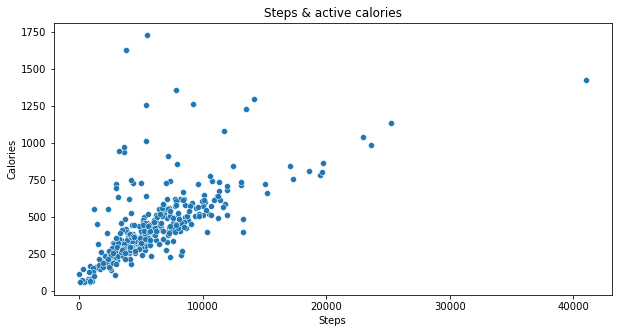

In [19]:
plt.figure(figsize=(10,5))
plt.title('Steps & active calories')
plt.xlabel('Steps')
plt.ylabel('Calories')
sns.scatterplot(by_day['steps'],by_day['calories'])
plt.show()

Above we can see that number of steps is correlated with calories. There are a couple of outliers - above 40k steps in a day or 1750 burned "active" calories but I will leave them in as they are explainable (travel, cycling trips).

Now I will explore the data by month

In [20]:
import calendar  # this library will help me convert numbers into month and weekday names
by_month = by_day.groupby(by_day.index.month).mean() # grouping days by month and ggetting the mean
by_month.index = list(calendar.month_name)[1:]

<AxesSubplot:>

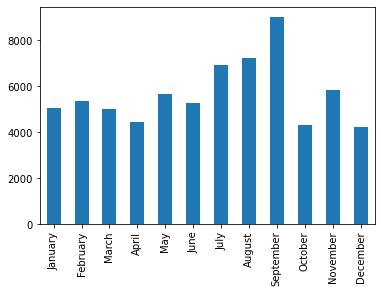

In [21]:
by_month['steps'].plot(kind='bar')


Above we can see that in September I have taken the most steps on average and the least in October.

Now I am gonna explore the data by weekdays:

In [22]:
by_weekday = by_day.groupby(by_day.index.dayofweek).mean()
by_weekday.index = ['Monday', 'Tuesday',
                          'Wednesday', 'Thursday',
                          'Friday', 'Saturday',
                          'Sunday']

<AxesSubplot:>

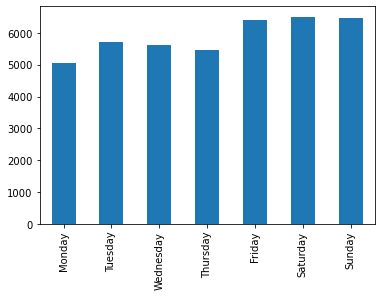

In [23]:
by_weekday['steps'].plot(kind='bar')


On the weekends I took the most steps on average - around 6,5k.

/Users/dominykabortnikaite/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


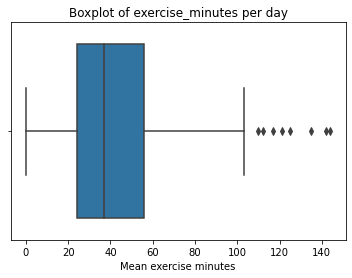

In [24]:
sns.boxplot(by_day['exercise_minutes'])
plt.title('Boxplot of exercise_minutes per day')
plt.xlabel('Mean exercise minutes')
plt.show()

Above we can see that my exercise minutes ranged from slightly above 20 to a bit less than 60, with the median around the 40min mark. 

Let's look at the relation between the numerical values.

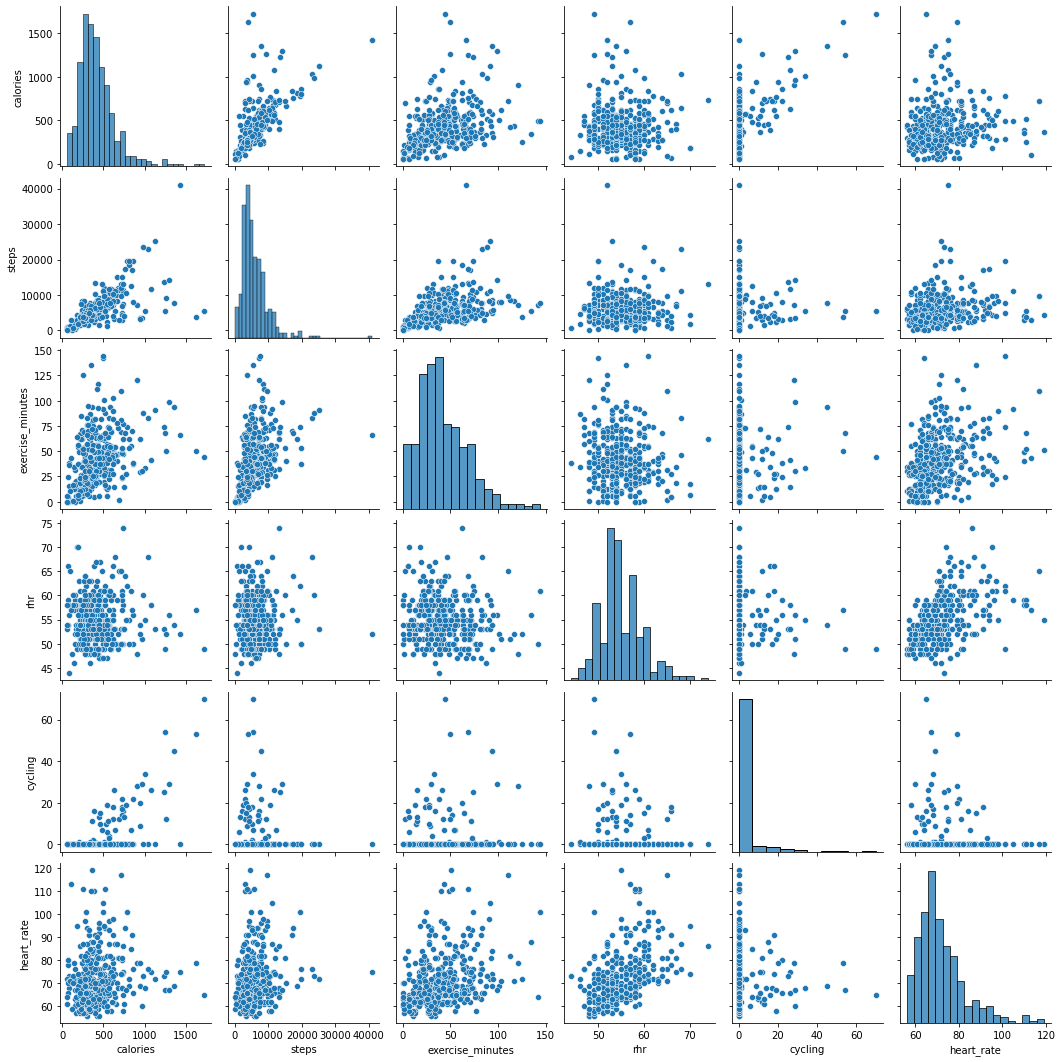

In [25]:
df_numerical = by_day[['calories','steps','exercise_minutes', 'rhr', 'cycling', 'heart_rate']]
sns.pairplot(df_numerical)
plt.show()

There is a correlation between steps and calories, steps and exercise minutes, exercise minutes and heart rate, exercise minutes and calories.

Now I am going to display the correlation values between the numerical columns: 

In [26]:
by_day.corr()

,steps,calories,exercise_minutes,heart_rate,cycling,rhr
steps,1.000000,0.662359,0.431896,0.161570,0.011940,0.036329
calories,0.662359,1.000000,0.375181,0.106323,0.657944,-0.009767
exercise_minutes,0.431896,0.375181,1.000000,0.309359,0.063708,-0.112153
heart_rate,0.161570,0.106323,0.309359,1.000000,-0.027990,0.475926
cycling,0.011940,0.657944,0.063708,-0.027990,1.000000,-0.048276
rhr,0.036329,-0.009767,-0.112153,0.475926,-0.048276,1.000000


<AxesSubplot:>

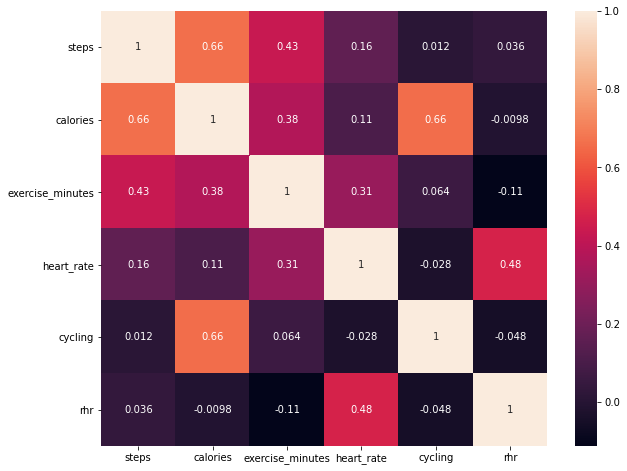

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(by_day.corr(),annot=True)

As expected, there is a moderate correlation between steps and calories (0,66) and cycling and calories (0,66), as well as positive low correlation between exercise_minutes and calories (0,38). Heart rate has a positive low correlation with exercise minuts too (0,31). 

## 3. Feature engineering and establishing a baseline

In order to make and evaluate predicitons, I need to establish a baseline measure that I will want my model to beat.
I will create a formula that will calculate estimated calories burned based on steps and exercise minutes.


Using [online RMR calculator](https://www.omnicalculator.com/health/rmr)
, based on my height and weight, I learned that my resting metabolic rate __RMR is 1525kcal__. (That's how many calories I burn at rest).

The calories that show up in the data from my Apple Watch, are called "active calories" and they are calculated using the following formula *Active Calories = Total Calories – BMR*. For this project I will use total calories burned, so I will add a "total_calories" to the dataframe: 


In [28]:
RMR = 1525
by_day['total_calories'] = by_day["calories"] + RMR

Now I want to translate exercise minutes into burned calories.
I will use this formula: __Total calories burned = Duration(in minutes) * (MET* 3.5 * weight in kg)/200__ [(source)](https://www.verywellfit.com/how-many-calories-you-burn-during-exercise-4111064).

MET (metabolic equivalent for task) is a unit that estimates the amount of energy used by the body during physical activity. There is no way for me to know what MET score was reached every time the "exercise_minutes" were tracked, so based on my understanding of my personal activity I will use 3 which is considered to be on the low end of Moderate-intensity physical activity.[(source)](https://www.verywellfit.com/met-the-standard-metabolic-equivalent-3120356).

Using the formula above, I will create a new variable called "exercise_calories":



In [29]:
by_day['exercise_calories']= by_day["exercise_minutes"] * (3 * 3.5 * 64) / 200


Now, I will calculate and add calories burned based on steps. It is estimated that an average person burns 0.04 kcal per step. [(source)](https://www.livestrong.com/article/238020-how-to-convert-pedometer-steps-to-calories/).

In [30]:
by_day['steps_calories'] =  by_day['steps'] * 0.04

Now I will create a "est_calories" column that will show the estimated burned calories based on exercise minutes and steps:

In [31]:
by_day['est_calories'] = by_day['steps_calories'] + by_day['exercise_calories'] + RMR

Last column I'll add will show by how much my estimate is wrong:

In [32]:
by_day['error'] =  by_day['total_calories'] - by_day['est_calories'] 
by_day

,steps,calories,exercise_minutes,heart_rate,cycling,rhr,total_calories,exercise_calories,steps_calories,est_calories,error
@creationDate,,,,,,,,,,,
2020-05-02 00:00:00+01:00,1457,152,31,71,0,59,1677,104.16,58.28,1687.44,-10.44
2020-05-04 00:00:00+01:00,2526,215,14,66,0,54,1740,47.04,101.04,1673.08,66.92
2020-05-05 00:00:00+01:00,5192,283,13,64,0,52,1808,43.68,207.68,1776.36,31.64
2020-05-06 00:00:00+01:00,1886,180,15,64,0,49,1705,50.40,75.44,1650.84,54.16
2020-05-07 00:00:00+01:00,3748,252,125,72,0,52,1777,420.00,149.92,2094.92,-317.92
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-06 00:00:00+01:00,3494,277,24,69,0,58,1802,80.64,139.76,1745.40,56.60
2021-12-10 00:00:00+01:00,5007,321,30,93,0,63,1846,100.80,200.28,1826.08,19.92
2021-12-15 00:00:00+01:00,3704,252,52,111,0,58,1777,174.72,148.16,1847.88,-70.88


In [33]:
abe = abs(by_day['error'].mean(axis=0))
print('Average baseline error: ', abe)


Average baseline error:  49.75820105820104


Now I have a goal for my model to beat the average error of 50. 

## 4.Predictive model

I will now start training my model. First, I need to split the data into test and train data. I will use steps, exercise_minutes, heart_rate, and cycled distance to predict total calories burned.

In [34]:
X = by_day[['steps','exercise_minutes','heart_rate','cycling', 'rhr']] 
y = by_day['total_calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=55)


I will use random forest regression algorithm because the target value is coninuous. I'm setting the number of trees to 100.


In [35]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 12)
rf.fit(X_train, y_train);

My model has now been trained to learn the relationships between the features (X) and the targets (y). 

## 5. Evaluating the model

Now I'm going to make predictions on the test set and calculate the absolute errors.

In [36]:
y_test_p = rf.predict(X_test)

errors = abs(y_test_p - y_test)
mae = round(np.mean(errors)) #calculating mean absolute error
improvement = abe - mae # the difference between the baseline and model errors

print('Mean Absolute Error:', round(np.mean(errors)))
print('The difference between the mean absolute error of the model and the baseline is:', round(improvement), " kcal")

Mean Absolute Error: 61
The difference between the mean absolute error of the model and the baseline is: -11  kcal


Unfortunately, the model does not beat the baseline measure. It is less accurate by 11 kcal.

Now I will calculate the R^2 . 

In [37]:
r2 = r2_score(y_test, y_test_p)
print('R2 is', round(r2, 2), ", meaning ", round((r2*100)), "% of variation is explained by the model")

R2 is 0.83 , meaning  83 % of variation is explained by the model


Let's see how the predicted values compare to the actual values.

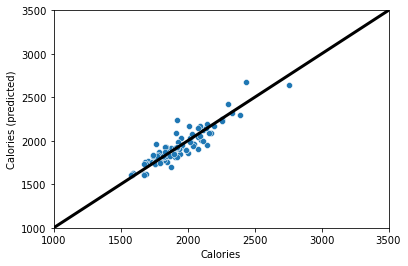

In [38]:
sns.scatterplot(x=y_test,y=y_test_p)
plt.xlim(1000, 3500) 
plt.ylim(1000, 3500) 
plt.plot([0, 1.5e6], [0, 1.5e6], color='black', lw=3) 
plt.xlabel('Calories')
plt.ylabel('Calories (predicted)')
plt.show()


The plot shows that 
predictions are around the same in terms of accuracy with higher calories as well as lower calories.

## Conclusion

The prediction model turned out to be quite accurate with R2 of 0.83 and the mean absoulute error of 61kcal. However, a baseline model could calculate the calories more accurately by taking into account person's height, weight and using different established formulas for calculating calories. In practical context, this model would not be very handy as calories can be calculated quite precisely already rather than predicted.  